In [52]:
from typing import List, Optional
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_groq import ChatGroq
from langchain_core.prompts import ChatPromptTemplate
from dotenv import load_dotenv

# from .models import FinancialAnalysisState
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import requests
from statsmodels.tsa.arima.model import ARIMA
import google.generativeai as genai
import os

load_dotenv()

from pydantic import BaseModel
class FinancialAnalysisState(BaseModel):
    stock_symbol: str
    raw_data: Optional[dict] = None
    preprocessed_data: Optional[dict] = None
    predictions: Optional[dict] = None
    analysis_report: Optional[str] = None
    visualization_path: Optional[str] = None
    news: Optional[List[str]] = None
    error: Optional[str] = None



def chatbot(state: FinancialAnalysisState):
    return state

def fetch_yahoo_finance_data(state: FinancialAnalysisState):
    try:
        stock_symbol = state["stock_symbol"]

        # Fetch stock data from Yahoo Finance
        stock_data = yf.download(stock_symbol, period='1mo', interval='1d')

        return {
            "raw_data": stock_data.to_dict(),
        }

    except Exception as e:
        return {"error": str(e)}


def preprocess_data(state: FinancialAnalysisState):
    try:
        data = state["stock_data"]

        if data is None or data.empty:
            return pd.DataFrame()

        data = data.dropna()
        data.index = pd.to_datetime(data.index)  # Ensure datetime index
        data['Returns'] = data['Close'].pct_change()
        data['Log_Returns'] = np.log(1 + data['Returns'])
        return {"preprocessed_data": data}

    except Exception as e:
        print(f"Error processing data: {e}")
        return {"error": str(e)}


def scrape_financial_news(state: FinancialAnalysisState):
    stock_symbol = state["stock_symbol"]
    url = f'https://finance.yahoo.com/quote/{stock_symbol}'
    try:
        response = requests.get(url, headers={
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
        })

        # Raise an exception for bad status codes
        response.raise_for_status()

        soup = BeautifulSoup(response.text, 'html.parser')

        # Extract relevant news (this is a basic implementation)
        news_elements = soup.find_all('h3', class_='Mb(5px)')
        news = [elem.get_text() for elem in news_elements[:5]]

        return {"news": news}
    except Exception as e:
        print(f"Error scraping news: {e}")
        return []


def generate_predictions(state: FinancialAnalysisState):
    try:
        # Check if preprocessed data exists
        if not state.preprocessed_data:
            return state

        # Convert preprocessed data back to DataFrame
        data = pd.DataFrame.from_dict(state.preprocessed_data)

        # Prepare data for ARIMA
        close_prices = data['Close']

        # Fit ARIMA model
        model = ARIMA(close_prices, order=(5, 1, 0))
        model_fit = model.fit()

        # Generate forecast for next 7 days
        forecast = model_fit.forecast(steps=7)
        forecast_df = pd.DataFrame({
            'Predicted_Close': forecast,
            'Date': pd.date_range(start=close_prices.index[-1], periods=8)[1:]
        }).set_index('Date')

        # Update state with predictions
        state.predictions = forecast_df.to_dict()

        return state
    except Exception as e:
        state.error = str(e)
        return state


def generate_report(state: FinancialAnalysisState):
    try:
        # Check if predictions and preprocessed data exist
        if not state.predictions or not state.preprocessed_data:
            state.error = "Insufficient data for report generation"
            return state

        # Convert data back to DataFrame
        preprocessed_data = pd.DataFrame.from_dict(state.preprocessed_data)
        predictions = pd.DataFrame.from_dict(state.predictions)

        # Calculate key metrics
        last_close_price = float(preprocessed_data['Close'].iloc[-1])
        predicted_prices = predictions['Predicted_Close']

        # Calculate price change percentage
        price_change_pct = (
            predicted_prices.iloc[-1] - last_close_price) / last_close_price * 100
        volatility = float(preprocessed_data['Returns'].std() * 100)

        # Prepare predicted prices string
        predicted_prices_str = "\n".join([
            f"  {date.date()}: {price:.2f}"
            for date, price in predicted_prices.items()
        ])

        # Prepare context for Gemini
        context = f"""
        Comprehensive Stock Analysis Report

        Stock Symbol: {state.stock_symbol}
        Last Closing Price: {last_close_price:.2f}
        
        Predicted Price Trajectory:
        {predicted_prices_str}
        
        Key Insights:
        - Projected Price Change: {price_change_pct:.2f}%
        - Historical Volatility: {volatility:.2f}%
        
        Detailed Market Analysis:
        Provide a comprehensive analysis of the stock's potential movement, 
        including fundamental and technical insights. Consider:
        1. Current market trends
        2. Potential growth factors
        3. Risk assessment
        4. Short-term and long-term investment outlook
        """

        # Use Gemini for generating insights
        model = genai.GenerativeModel('gemini-2.0-flash')
        response = model.generate_content(context)

        # Update state with analysis report
        state.analysis_report = response.text

        return state
    except Exception as e:
        state.error = str(e)
        return state


def create_visualization(state: FinancialAnalysisState):
    try:
        # Check if data exists
        if not state.preprocessed_data or not state.predictions:
            state.error = "Insufficient data for visualization"
            return state

        # Convert data back to DataFrame
        preprocessed_data = pd.DataFrame.from_dict(state.preprocessed_data)
        predictions = pd.DataFrame.from_dict(state.predictions)

        # Create visualization directory if it doesn't exist
        os.makedirs('visualizations', exist_ok=True)

        plt.figure(figsize=(12, 6))

        # Plot historical prices
        plt.plot(preprocessed_data['Close'], label='Historical Prices')

        # Plot predictions
        plt.plot(predictions.index, predictions['Predicted_Close'],
                 color='red', label='Predicted Prices')

        plt.title(f'{state.stock_symbol} Price Forecast')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.legend()
        plt.xticks(rotation=45)

        # Save visualization
        visualization_path = f'visualizations/{state.stock_symbol}_forecast.png'
        plt.savefig(visualization_path, bbox_inches='tight')
        plt.close()

        # Update state with visualization path
        state.visualization_path = visualization_path

        return state
    except Exception as e:
        state.error = str(e)
        return state

def _route(state):
    if state["stock_symbol"] is None:
        return END
    else:
        return "fetch_yahoo_finance_data"

graph = StateGraph(FinancialAnalysisState)
graph.add_node("chatbot", chatbot)
graph.add_node("fetch_yahoo_finance_data", fetch_yahoo_finance_data)
graph.add_node("preprocess_data", preprocess_data)
graph.add_node("scrape_financial_news", scrape_financial_news)
graph.add_node("generate_predictions", generate_predictions)
graph.add_node("generate_report", generate_report)
graph.add_node("create_visualization", create_visualization)


graph.add_conditional_edges("chatbot", _route, {END:END, "fetch_yahoo_finance_data":"fetch_yahoo_finance_data"})
graph.add_edge("chatbot","fetch_yahoo_finance_data")
graph.add_edge("fetch_yahoo_finance_data", "preprocess_data")
graph.add_edge("preprocess_data", "scrape_financial_news")
graph.add_edge("scrape_financial_news", "generate_predictions")
graph.add_edge("generate_predictions", "generate_report")
graph.add_edge("generate_report", "create_visualization")
graph.add_edge("create_visualization", END)
graph.add_edge(START, "chatbot")

app = graph.compile()



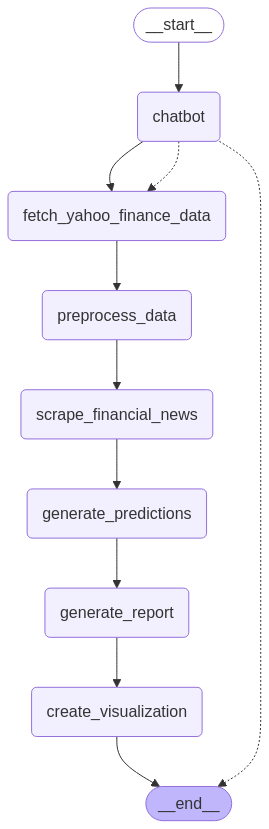

In [53]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    pass